# LLM embeddings for lung cancer risk prediction

In [70]:
import pandas as pd
from openai import OpenAI
import json
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import os

### Read the data containing all relevant patients with their medical history

In [71]:
root = os.getcwd()

data = pd.read_csv(f'{root}/dataset_all.csv')
# only keep the first entry for each patient to avoid duplicates
data.drop_duplicates(subset='patient_id', keep='first', inplace=True)
# keep the features to analyze
data = data[['patient_id', 'age', 'educat', 'ethnic', 'gender', 'race', 'diagcopd', 'height', 'weight', 'smokeage', 'pkyr', 'smokeday', 'smokeyr', 'cigsmok', 'lung_cancer']]
data = data.reset_index(drop=True)
print(f'Number of patient entries: {data.shape[0]}')
data.head()

Number of patient entries: 2862


,patient_id,age,educat,ethnic,gender,race,diagcopd,height,weight,smokeage,pkyr,smokeday,smokeyr,cigsmok,lung_cancer
0,127102,59,5,2,1,1,0.0,68.0,235.0,13.0,30.00,20,30,0,0
1,108275,57,3,2,1,1,0.0,72.0,190.0,16.0,92.25,45,41,1,0
2,123819,69,5,2,1,1,0.0,72.0,210.0,13.0,112.50,45,50,0,0
3,209095,59,3,2,1,1,0.0,67.0,167.0,8.0,76.50,30,51,1,1
4,215151,67,5,2,1,1,0.0,63.0,185.0,15.0,75.00,30,50,0,1


### Map the categories to the corresponding text so that the text data can be embedded

In [72]:
data['ethnic'] = data['ethnic'].map({
    1: "Hispanic or Latino",
    2: "Neither Hispanic nor Latino",
    7: "Participant refused to answer",
    95: "Missing data form - form is not expected to ever be completed",
    98: "Missing - form was submitted and the answer was left blank",
    99: "Unknown"
})

data['race'] = data['race'].map({
    1: "White",
    2: "Black or African-American",
    3: "Asian",
    4: "American Indian or Alaskan Native",
    5: "Native Hawaiian or Other Pacific Islander",
    6: "More than one race",
    7: "Participant refused to answer",
    95: "Missing data form - form is not expected to ever be completed",
    96: "Missing - no response",
    98: "Missing - form was submitted and the answer was left blank",
    99: "Unknown"
})


data['gender'] = data['gender'].map({
    1: "male",
    2: "female",
})

data['cigsmok'] = data['cigsmok'].map({
    0: 'not',
    1: ''
})


In [73]:
data.head()

,patient_id,age,educat,ethnic,gender,race,diagcopd,height,weight,smokeage,pkyr,smokeday,smokeyr,cigsmok,lung_cancer
0,127102,59,5,Neither Hispanic nor Latino,male,White,0.0,68.0,235.0,13.0,30.00,20,30,not,0
1,108275,57,3,Neither Hispanic nor Latino,male,White,0.0,72.0,190.0,16.0,92.25,45,41,,0
2,123819,69,5,Neither Hispanic nor Latino,male,White,0.0,72.0,210.0,13.0,112.50,45,50,not,0
3,209095,59,3,Neither Hispanic nor Latino,male,White,0.0,67.0,167.0,8.0,76.50,30,51,,1
4,215151,67,5,Neither Hispanic nor Latino,male,White,0.0,63.0,185.0,15.0,75.00,30,50,not,1


### Create the template text containing the chosen information for the embeddings

In [34]:
def templatize(age, educat, ethnic, gender, height, weight, pkyr, smokeyr, smokeage, smokeday, cigsmok):
    """
    Generate the text to embed, based on patient information from the tabular data.

    Parameters:
    age (int): Age of the patient.
    educat (int): Years of education of the patient.
    ethnic (str): Ethnic group of the patient.
    gender (str): Gender of the patient.
    height (float): Height of the patient in inches.
    weight (float): Weight of the patient in pounds.
    pkyr (float): Package years of smoking for the patient.
    smokeyr (int): Number of years the patient has smoked.
    smokeage (float): Age at which the patient started smoking.
    smokeday (int): Average number of cigarettes smoked per day.
    cigsmok (str): Current smoking status of the patient.

    Returns:
    str: A paragraph describing the patient based on the tabular data.
    """
    
    template = f"The patient is {age} years old, has {educat} years of education, belongs to ethnic group {ethnic}, is {gender} gender, and has a height of {height} inches and weight of {weight} pounds. The patient has a history of {pkyr} package years of smoking and has smoked for {smokeyr} years. The patient started smoking at {smokeage} years and smokes an average of {smokeday} cigarettes per day. At the time of the trial the patient was {cigsmok} smoking."

    return template


def templatize_no_gender(age, educat, ethnic, height, weight, pkyr, smokeyr, smokeage, smokeday, cigsmok):
    """
    Generate the text to embed, based on patient information from the tabular data. The text does not contain the gender of the patient to avoid bias.

    Parameters:
    age (int): Age of the patient.
    educat (int): Years of education of the patient.
    ethnic (str): Ethnic group of the patient.
    height (float): Height of the patient in inches.
    weight (float): Weight of the patient in pounds.
    pkyr (float): Package years of smoking for the patient.
    smokeyr (int): Number of years the patient has smoked.
    smokeage (float): Age at which the patient started smoking.
    smokeday (int): Average number of cigarettes smoked per day.
    cigsmok (str): Current smoking status of the patient.

    Returns:
    str: A paragraph describing the patient based on the tabular data without the gender.
    """
        
    template = f"The patient is {age} years old, has {educat} years of education, belongs to ethnic group {ethnic}, and has a height of {height} inches and weight of {weight} pounds. The patient has a history of {pkyr} package years of smoking and has smoked for {smokeyr} years. The patient started smoking at {smokeage} years and smokes an average of {smokeday} cigarettes per day. At the time of the trial the patient was {cigsmok} smoking."

    return template

In [6]:
# testing the function

# how many paragraphs to generate
end_index = 2

# boolean value if the gender should be included in the text
use_gender = True

for i, row in data.iterrows():
    if i == end_index:
        break
    
    age = row['age']
    educat = row['educat']
    ethnic = row['ethnic']
    gender = row['gender']
    height = row['height']
    weight = row['weight']
    pkyr = row['pkyr']
    smokeyr = row['smokeyr']
    smokeage = row['smokeage']
    smokeday = row['smokeday']
    cigsmok = row['cigsmok']

    if use_gender:
        embedding_sentence = templatize(age, educat, ethnic, gender, height, weight, pkyr, smokeyr, smokeage, smokeday, cigsmok)
    else:
        embedding_sentence = templatize_no_gender(age, educat, ethnic, height, weight, pkyr, smokeyr, smokeage, smokeday, cigsmok)

    print(embedding_sentence)


The patient is 59 years old, has 5 years of education, belongs to ethnic group Neither Hispanic nor Latino, is male gender, and has a height of 68.0 inches and weight of 235.0 pounds. The patient has a history of 30.0 package years of smoking and has smoked for 30 years. The patient started smoking at 13.0 years and smokes an average of 20 cigarettes per day. At the time of the trial the patient was not smoking.


### Create the embeddings with the embedding model from OpenAI
To use the OpenAI API, you need to set the OPENAI_API_KEY environment variable

In [36]:
client = OpenAI()

# empty dictionary to store the embeddings with the patient id as the key
embeddings = {}

# boolean value if the gender should be included in the text
use_gender = True

for i, row in tqdm.tqdm(data.iterrows()):

    age = row['age']
    educat = row['educat']
    ethnic = row['ethnic']
    gender = row['gender']
    height = row['height']
    weight = row['weight']
    pkyr = row['pkyr']
    smokeyr = row['smokeyr']
    smokeage = row['smokeage']
    smokeday = row['smokeday']
    cigsmok = row['cigsmok']
    patient_id = row['patient_id']

    if use_gender:
        embedding_sentence = templatize(age, educat, ethnic, gender, height, weight, pkyr, smokeyr, smokeage, smokeday, cigsmok)
    else:
        embedding_sentence = templatize_no_gender(age, educat, ethnic, height, weight, pkyr, smokeyr, smokeage, smokeday, cigsmok)

    response = client.embeddings.create(
        input=embedding_sentence,
        model="text-embedding-3-small"
    )

    embeddings[patient_id] = response.data[0].embedding


with open('embeddings_nlst.json', 'w') as f:
    json.dump(embeddings, f)

2862it [54:27,  1.14s/it]


In [74]:
# load the embeddings from the json file
with open('embeddings_nlst.json', 'r') as f:
    # data_j = json.load(f)
    data_j = f.read()
    data_j = json.loads(data_j)

    # print the number of patients and the length of the embeddings
    print(f'Number of patients: {len(data_j.keys())}')
    print(f'Embedding size: {len(data_j[list(data_j.keys())[0]])}')


Number of patients: 2862
Embedding size: 1536


In [75]:
df = pd.DataFrame(data_j).T
df['patient_id'] = df.index
df = df.reset_index(drop=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1527,1528,1529,1530,1531,1532,1533,1534,1535,patient_id
0,0.038199,-0.027934,0.020057,0.025164,-0.005365,0.004385,0.017772,-0.013507,0.012212,-0.009946,...,-0.024819,-0.015703,0.000400,0.006294,0.006521,0.004325,-0.030437,-0.041927,-0.015142,127102
1,0.026808,-0.035599,0.026527,0.032439,-0.015353,0.008161,0.016564,-0.015557,0.008460,-0.008849,...,-0.034350,-0.012467,0.004603,0.012716,0.005906,0.004345,-0.030018,-0.048162,-0.014589,108275
2,0.036072,-0.030232,0.031081,0.039546,-0.012569,0.003444,0.010497,-0.016299,0.010182,-0.014653,...,-0.027401,-0.011681,0.006207,0.016750,0.004831,0.000554,-0.025292,-0.043945,-0.021728,123819
3,0.034089,-0.038959,0.034622,0.019835,-0.006484,-0.000596,0.016068,-0.011369,0.006192,-0.015751,...,-0.033049,-0.016766,0.005926,0.011357,0.003884,0.009467,-0.029346,-0.049308,-0.011978,209095
4,0.035818,-0.024893,0.025213,0.037404,-0.011935,-0.000131,0.019917,-0.012210,0.016758,-0.018139,...,-0.028705,-0.012882,-0.000932,0.015478,-0.000484,0.007349,-0.029959,-0.046896,-0.016949,215151


In [76]:
# add the lung cancer status of each patient to the dataframe
df['lung_cancer'] = data['lung_cancer']

df.head()

0       0
1       0
2       0
3       1
4       1
       ..
2857    0
2858    0
2859    1
2860    0
2861    1
Name: lung_cancer, Length: 2862, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,1528,1529,1530,1531,1532,1533,1534,1535,patient_id,lung_cancer
0,0.038199,-0.027934,0.020057,0.025164,-0.005365,0.004385,0.017772,-0.013507,0.012212,-0.009946,...,-0.015703,0.000400,0.006294,0.006521,0.004325,-0.030437,-0.041927,-0.015142,127102,0
1,0.026808,-0.035599,0.026527,0.032439,-0.015353,0.008161,0.016564,-0.015557,0.008460,-0.008849,...,-0.012467,0.004603,0.012716,0.005906,0.004345,-0.030018,-0.048162,-0.014589,108275,0
2,0.036072,-0.030232,0.031081,0.039546,-0.012569,0.003444,0.010497,-0.016299,0.010182,-0.014653,...,-0.011681,0.006207,0.016750,0.004831,0.000554,-0.025292,-0.043945,-0.021728,123819,0
3,0.034089,-0.038959,0.034622,0.019835,-0.006484,-0.000596,0.016068,-0.011369,0.006192,-0.015751,...,-0.016766,0.005926,0.011357,0.003884,0.009467,-0.029346,-0.049308,-0.011978,209095,1
4,0.035818,-0.024893,0.025213,0.037404,-0.011935,-0.000131,0.019917,-0.012210,0.016758,-0.018139,...,-0.012882,-0.000932,0.015478,-0.000484,0.007349,-0.029959,-0.046896,-0.016949,215151,1


## PCA

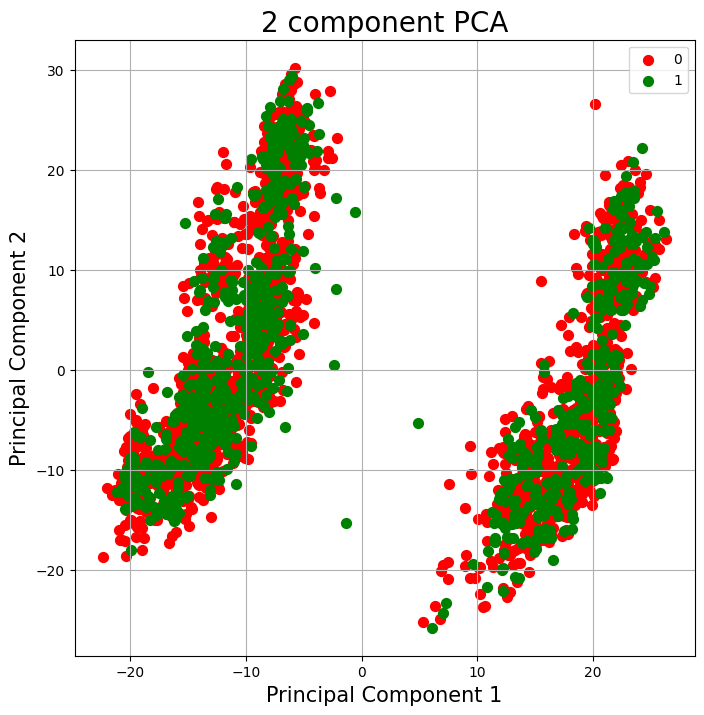

In [77]:
# Separate the features and the target
X = df.drop('lung_cancer', axis=1)  # Features
y = df['lung_cancer']  # Target

X.columns = X.columns.astype(str)

# Standardizing the features
X = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# Concatenating the target variable for visualization
finalDf = pd.concat([principalDf, df[['lung_cancer']]], axis=1)

# Plotting
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['lung_cancer'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


## SVC

In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


# Separate the features and the target
X = df.drop(['lung_cancer', 'patient_id'], axis=1)
y = df['lung_cancer']

X.columns = X.columns.astype(str)

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Initialize the Support Vector Classifier
classifier = SVC(kernel='linear', random_state=42)

# Train the classifier
classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[436 160]
 [176  87]]
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       596
           1       0.35      0.33      0.34       263

    accuracy                           0.61       859
   macro avg       0.53      0.53      0.53       859
weighted avg       0.60      0.61      0.61       859



## XGBoost

In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

# Separate the features and the target
X = df.drop(['lung_cancer', 'patient_id'], axis=1)
y = df['lung_cancer']

X.columns = X.columns.astype(str)

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

classifier = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the classifier
classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[523  73]
 [222  41]]
              precision    recall  f1-score   support

           0       0.70      0.88      0.78       596
           1       0.36      0.16      0.22       263

    accuracy                           0.66       859
   macro avg       0.53      0.52      0.50       859
weighted avg       0.60      0.66      0.61       859

